<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [68]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [69]:
df.shape

(104640, 74)

In [70]:
df =df.iloc[np.random.permutation(np.arange(104640).reshape(-1,60)).ravel()]

In [71]:
# df.to_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/shuffled_data.csv',index=False)

In [72]:
df.shape

(104640, 74)

In [73]:
df.pop('song_id')
df.pop('frame_num')

86340     0
86341     1
86342     2
86343     3
86344     4
         ..
29395    55
29396    56
29397    57
29398    58
29399    59
Name: frame_num, Length: 104640, dtype: int64

In [74]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
86340,0.149,0.024
86341,0.152,0.018
86342,0.144,0.012
86343,0.136,-0.011
86344,0.138,-0.001


In [75]:
df.pop('valence')
df.pop('arousal')

86340    0.024000
86341    0.018000
86342    0.012000
86343   -0.011000
86344   -0.001000
           ...   
29395    0.342557
29396    0.346522
29397    0.345609
29398    0.345690
29399    0.343687
Name: arousal, Length: 104640, dtype: float64

In [76]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
86340,0.120605,0.038553,1577.434054,1671.046392,2250.219727,18.183141,0.003548,0.000029,-442.687195,112.834274,-13.682774,-32.775444,-3.775378,4.155223,-27.204559,-9.475449,13.916375,-15.171112,-24.885111,-23.455908,-8.788421,9.080820,0.303365,-2.910561,-7.393029,-4.228126,0.438693,-12.561666,0.369850,0.181056,0.151105,0.235034,0.650926,0.256763,0.172141,0.828379,0.239882,0.103425,0.645466,0.058582,0.175454,1.000000,0.163177,0.212558,0.620084,0.390085,0.116848,0.925773,0.387404,0.158432,0.958756,0.279527,0.318741,0.481833,0.230939,0.724031,0.383059,0.311966,1.000000,0.602575,0.446670,0.786495,0.658540,0.305098,0.069935,-0.067646,0.076696,-0.087424,0.034014,-0.048207
86341,0.184570,0.086144,2317.171423,1989.845062,4231.274414,17.841289,0.001813,0.003158,-190.000504,84.880325,-39.797684,-3.060449,5.649426,10.913260,-28.205669,1.514402,11.492004,-41.236710,-16.413885,-7.118959,-38.735615,-12.488440,-14.545168,21.246307,12.295847,17.781853,-19.499474,4.713183,0.009959,0.221803,0.159048,0.389888,0.700065,0.255547,1.000000,0.751510,0.235262,0.060287,0.316950,0.059930,0.077361,0.384289,0.160255,0.403686,0.904175,0.389569,0.166357,0.889498,0.385300,0.026866,0.386009,0.282417,0.005470,0.119766,0.235516,0.105243,0.559785,0.318234,0.454249,1.000000,0.443215,0.062020,0.518760,0.302687,0.008373,-0.004198,0.030584,-0.017830,0.010579,-0.002771
86342,0.117188,0.052132,2008.069167,2452.510632,4532.739258,16.084488,0.004401,0.164401,-196.750641,111.722649,0.924732,-9.006064,-13.416687,-1.960280,-8.148701,10.587578,22.875343,-13.403354,-4.272635,-23.539728,-18.215202,0.231350,5.764665,-4.071016,7.429517,10.884590,-1.014562,5.679839,0.031768,0.254755,0.166420,0.042155,0.367593,0.254436,0.020217,0.265739,0.230777,0.006680,0.161439,0.061000,0.070156,0.384032,0.157587,0.342242,0.630120,0.389387,0.062298,0.419727,0.383629,0.029790,0.235979,0.285042,0.109694,0.295305,0.239185,0.239214,0.602293,0.324020,1.000000,1.000000,0.439701,0.176290,0.544993,0.300294,-0.020647,0.004909,-0.026391,-0.216812,0.038562,-0.014340
86343,0.087891,0.062946,1698.216189,2044.232311,2271.752930,15.592293,0.000921,0.002156,-229.037949,133.627319,-18.604656,-32.831970,-24.311275,10.498560,-22.546434,-18.985069,31.289640,-30.233847,-10.148164,-32.725094,-11.926043,-5.710715,11.476934,11.509021,10.634457,-4.279814,-13.021610,-8.175509,0.023744,0.368687,0.173198,0.033033,0.404089,0.253430,0.008711,0.247435,0.226488,0.003171,0.132122,0.061786,0.022159,0.287149,0.155139,0.112082,0.468072,0.389473,0.028217,0.269566,0.382333,0.009150,0.158682,0.287399,0.037807,0.252091,0.241991,0.132128,0.450816,0.329287,1.000000,1.000000,0.436258,0.273787,0.681820,0.298022,-0.016818,-0.028408,-0.059435,-0.317186,0.059754,0.003157
86344,0.082520,0.038417,1395.995262,1766.972044,2088.720703,15.198699,0.002598,0.030531,-230.648941,154.530579,-20.657394,-14.482957,10.421513,1.719326,-22.083229,4.012653,-9.869968,-1.905949,-5.305861,-11.045206,-7.280683,-19.989449,1.178585,-1.503967,19.115238,9.408150,-2.600185,3.630439,0.088828,0.445482,0.179463,0.182169,0.583194,0.252431,0.056128,0.376039,0.222344,0.015445,0.199127,0.062284,0.045728,0.273308,0.152883,0.353474,0.684104,0.389771,1.000000,1.000000,0

In [77]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [78]:
# print(type(df))

In [79]:
features = df.to_numpy()
y = y.to_numpy()

In [80]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [81]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [82]:
train_X , train_y = features[0:1220] , y[0:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [83]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
# print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1220, 60, 70) train_y shape: (1220, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)


In [84]:
# print(features.shape)
# for i in range(1):
#   print(features)

In [85]:
# print(valence.shape)
# print(valence)

In [86]:
# print(type(features))
# print(features.shape)

In [87]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [88]:
history = model.fit(train_X, train_y, epochs=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/40
39/39 - 2s - loss: 0.0641 - val_loss: 0.0457
Epoch 2/40
39/39 - 1s - loss: 0.0470 - val_loss: 0.0451
Epoch 3/40
39/39 - 1s - loss: 0.0452 - val_loss: 0.0438
Epoch 4/40
39/39 - 1s - loss: 0.0449 - val_loss: 0.0442
Epoch 5/40
39/39 - 1s - loss: 0.0440 - val_loss: 0.0429
Epoch 6/40
39/39 - 1s - loss: 0.0433 - val_loss: 0.0425
Epoch 7/40
39/39 - 1s - loss: 0.0431 - val_loss: 0.0427
Epoch 8/40
39/39 - 1s - loss: 0.0427 - val_loss: 0.0427
Epoch 9/40
39/39 - 1s - loss: 0.0423 - val_loss: 0.0420
Epoch 10/40
39/39 - 1s - loss: 0.0420 - val_loss: 0.0417
Epoch 11/40
39/39 - 1s - loss: 0.0414 - val_loss: 0.0416
Epoch 12/40
39/39 - 1s - loss: 0.0408 - val_loss: 0.0426
Epoch 13/40
39/39 - 1s - loss: 0.0408 - val_loss: 0.0422
Epoch 14/40
39/39 - 1s - loss: 0.0406 - val_loss: 0.0420
Epoch 15/40
39/39 - 1s - loss: 0.0402 - val_loss: 0.0421
Epoch 16/40
39/39 - 1s - loss: 0.0406 - val_loss: 0.0414
Epoch 17/40
39/39 - 1s - loss: 0.0402 - val_loss: 0.0422
Epoch 18/40
39/39 - 1s - loss: 0.0402 - 

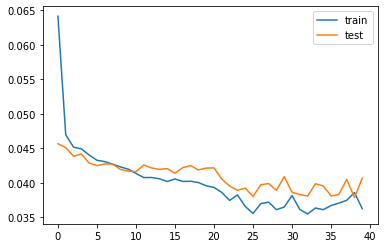

<Figure size 432x288 with 0 Axes>

In [89]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("training loss 350epochs_5layers")

In [90]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.04009827077388763
overall val_loss 0.041043439600616696


In [91]:
predicted_y = model.predict(test_X)


In [92]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [93]:
predicted_valence = predicted_y[:,:,0]
predicted_arousal = predicted_y[:,:,1]
test_valence = test_y[:,:,0]
test_arousal = test_y[:,:,1]

In [94]:
# for i in range(1):
  # print(predicted_valence[i])
  # print(predicted_arousal[i])
  # print(test_valence[i])
  # print(test_arousal[i])

In [95]:
predicted_valence = predicted_valence.reshape(31440,)
test_valence = test_valence.reshape(31440,)
predicted_arousal = predicted_arousal.reshape(31440,)
test_arousal = test_arousal.reshape(31440,)

In [96]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  
  print('RMSE : ',rmse)
  print('Pearson : ',pearson_corr)
  print('MAE : ',mae)
  print('R2 : ',r2)
  print('Spearman : ',spearman_corr,'\n')


In [97]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence 
RMSE :  0.21719269042171363
Pearson :  (0.46292870302274947, 0.0)
MAE :  0.1749527136564501
R2 :  0.1842195288337496
Spearman :  SpearmanrResult(correlation=0.47260065982115085, pvalue=0.0) 



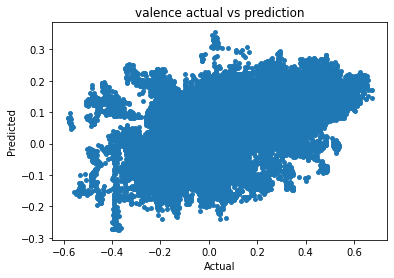

In [98]:
metrics(test_valence,predicted_valence,'valence')
graph_results(test_valence,predicted_valence,'valence actual vs prediction')


arousal 
RMSE :  0.1849302593179948
Pearson :  (0.7668661971058593, 0.0)
MAE :  0.14642718448397699
R2 :  0.5822740937067168
Spearman :  SpearmanrResult(correlation=0.7683828652660099, pvalue=0.0) 



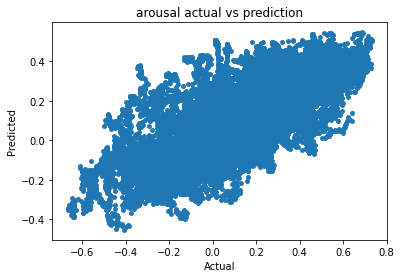

In [99]:
metrics(test_arousal,predicted_arousal,'arousal')
graph_results(test_arousal,predicted_arousal,'arousal actual vs prediction')